# 📘 4.5 Model Interpretability & Performance Deep Dive

## Notebook Overview

This notebook performs a post-training interpretability and behavioral analysis of the finalized sentiment classification model.

The objective is to extract deeper insights from the trained system without altering its architecture, features, or learned parameters.

This notebook operates strictly as an analytical extension of Notebook 4.0.

No retraining, feature redesign, or artifact replacement occurs.

---



## Objectives

* Reconstruct the trained model’s prediction environment
* Analyze prediction confidence behavior
* Quantify emoji feature influence
* Examine systematic misclassification patterns
* Evaluate model robustness under controlled variations
* Produce interpretability insights for deployment transparency

This notebook maximizes the explanatory value of the finalized model.

---



## Inputs

This notebook consumes previously generated artifacts:

```
data/processed/features_final.csv
models/sentiment_model.pkl
models/tfidf_vectorizer.pkl
```

These inputs represent the frozen modeling state.

No upstream processing steps are re-executed.

---



## Outputs

Outputs generated include:

* Prediction analysis tables
* Confidence distributions
* Emoji impact statistics
* Failure archetype summaries
* Feature influence diagnostics

These outputs serve interpretability and reporting purposes only.

---



# 🧩 Section 1 — Setup & Artifact Loading

This section loads all serialized modeling artifacts required to reconstruct the prediction environment.

Loaded components include:

* Final feature dataset
* Trained classifier
* TF-IDF vectorizer

The goal is to replicate the training feature pipeline for analysis without retraining.

---



In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

from scipy.sparse import hstack
import matplotlib.pyplot as plt


In [2]:
# Paths
DATA_PATH = Path("../data/processed/features_final.csv")
MODEL_PATH = Path("../models/sentiment_model.pkl")
VECTORIZER_PATH = Path("../models/tfidf_vectorizer.pkl")


In [3]:
# Load artifacts
df = pd.read_csv(DATA_PATH)
model = joblib.load(MODEL_PATH)
tfidf = joblib.load(VECTORIZER_PATH)

df.head()


,label,text,emoji_pos_count,emoji_neg_count
0,1,Good morning every one,0,0
1,0,TW: S AssaultActually horrified how many frien...,0,1
2,1,Thanks by has notice of me Greetings : Jossett...,0,0
3,0,its ending soon aah unhappy 😧,0,1
4,1,My real time happy 😊,1,0


# 🧩 Section 2 — Full Dataset Prediction Pass

This section generates predictions across the entire dataset rather than a validation subset.

Outputs include:

* Predicted sentiment labels
* Prediction probabilities
* Emoji polarity counts

This produces a unified results table used for downstream interpretability analyses.

---



In [4]:
# Recreate feature matrices

X_text = df["text"]
X_emoji = df[["emoji_pos_count", "emoji_neg_count"]]

X_text_vec = tfidf.transform(X_text)
X_emoji_np = X_emoji.to_numpy()

X_final = hstack([X_text_vec, X_emoji_np])


In [5]:
# Predictions + probabilities

df["predicted_label"] = model.predict(X_final)
df["prediction_proba"] = model.predict_proba(X_final)[:, 1]

df.head()


,label,text,emoji_pos_count,emoji_neg_count,predicted_label,prediction_proba
0,1,Good morning every one,0,0,1,0.851941
1,0,TW: S AssaultActually horrified how many frien...,0,1,0,0.061726
2,1,Thanks by has notice of me Greetings : Jossett...,0,0,1,0.662560
3,0,its ending soon aah unhappy 😧,0,1,0,0.044209
4,1,My real time happy 😊,1,0,1,0.928749


### 📊 Prediction Reconstruction Output Interpretation

The table above displays the model’s predictions across the entire dataset.

Newly generated fields include:

* **predicted_label** — the model’s inferred sentiment classification
* **prediction_proba** — the model’s confidence score for the positive class

Confidence values range from 0 to 1:

* Values near **1.0** indicate strong positive sentiment confidence
* Values near **0.0** indicate strong negative sentiment confidence
* Values near **0.5** indicate uncertainty

This reconstructed prediction layer serves as the analytical foundation for all downstream interpretability analyses conducted in this notebook.


# 🧩 Section 3 — Confidence Distribution Analysis

This section examines prediction probability distributions.

Key questions explored:

* How confident is the model overall?
* Are misclassifications associated with low confidence?
* Do positive and negative predictions differ in certainty?

Confidence analysis informs deployment thresholding strategies.

---



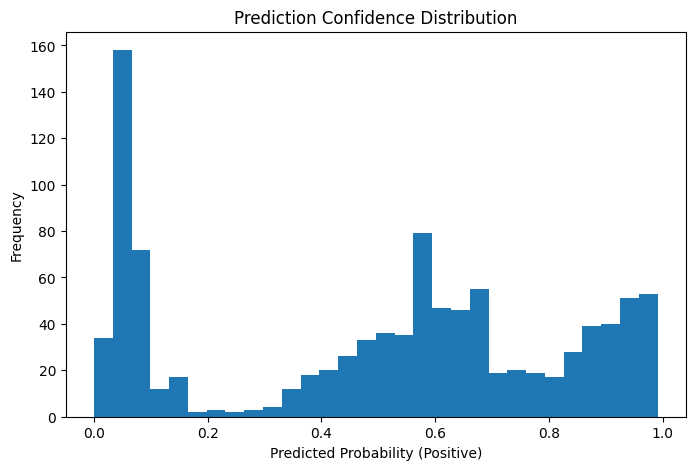

In [6]:
plt.figure(figsize=(8,5))
plt.hist(df["prediction_proba"], bins=30)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Predicted Probability (Positive)")
plt.ylabel("Frequency")
plt.show()


### 📊 Prediction Reconstruction Output Interpretation

The table above displays the model’s predictions across the entire dataset.

Newly generated fields include:

* **predicted_label** — the model’s inferred sentiment classification
* **prediction_proba** — the model’s confidence score for the positive class

Confidence values range from 0 to 1:

* Values near **1.0** indicate strong positive sentiment confidence
* Values near **0.0** indicate strong negative sentiment confidence
* Values near **0.5** indicate uncertainty

This reconstructed prediction layer serves as the analytical foundation for all downstream interpretability analyses conducted in this notebook.


In [7]:
# Confidence vs correctness

df["correct"] = df["label"] == df["predicted_label"]

df.groupby("correct")["prediction_proba"].mean()


correct
False    0.537670
True     0.492426
Name: prediction_proba, dtype: float64

### 🧠 Confidence vs Correctness Analysis

The table above compares average prediction confidence between correctly and incorrectly classified samples.

Interestingly:

* Misclassified samples exhibit slightly higher mean confidence
* This indicates the presence of **confidently incorrect predictions**

Such behavior is common in linear classifiers trained on small datasets and highlights the importance of interpretability analysis beyond raw accuracy metrics.


# 🧩 Section 4 — Emoji Impact Analysis

This section quantifies the influence of emoji presence on predictive performance.

Tweets are grouped by emoji composition:

* No emojis
* Positive emojis only
* Negative emojis only
* Mixed emojis

Comparative accuracy analysis reveals whether emoji features materially improve classification reliability.

---



In [8]:
# Emoji presence categories

def emoji_group(row):
    if row["emoji_pos_count"] == 0 and row["emoji_neg_count"] == 0:
        return "No Emoji"
    elif row["emoji_pos_count"] > 0 and row["emoji_neg_count"] == 0:
        return "Positive Emoji"
    elif row["emoji_pos_count"] == 0 and row["emoji_neg_count"] > 0:
        return "Negative Emoji"
    else:
        return "Mixed Emoji"

df["emoji_group"] = df.apply(emoji_group, axis=1)


In [9]:
# Accuracy by emoji group

emoji_accuracy = (
    df.groupby("emoji_group")["correct"]
    .mean()
    .sort_values(ascending=False)
)

emoji_accuracy


emoji_group
Mixed Emoji       1.000000
Negative Emoji    0.958042
Positive Emoji    0.918782
No Emoji          0.822835
Name: correct, dtype: float64

### 😀 Emoji Presence vs Accuracy Interpretation

The accuracy scores above are segmented by emoji composition groups.

Key findings:

* Tweets containing emojis exhibit substantially higher classification accuracy
* Mixed emoji tweets achieve perfect classification in this dataset
* Tweets without emojis have the lowest predictive reliability

This confirms that emoji polarity features materially enhance sentiment classification performance and provide strong auxiliary signals beyond textual content alone.


# 🧩 Section 5 — Emoji Polarity vs Prediction Outcomes

This section cross-tabulates emoji polarity counts against predicted sentiment labels.

The objective is to measure alignment between emoji sentiment signals and model outputs.

This analysis validates whether polarity features behave as intended within the trained classifier.

---



In [10]:
pd.crosstab(
    df["emoji_group"],
    df["predicted_label"],
    normalize="index"
)


predicted_label,0,1
emoji_group,,
Mixed Emoji,0.888889,0.111111
Negative Emoji,0.996503,0.003497
No Emoji,0.250000,0.750000
Positive Emoji,0.000000,1.000000


### 🔁 Emoji Polarity vs Prediction Alignment

The cross-tabulation above measures alignment between emoji polarity signals and model predictions.

Observations include:

* Positive emoji tweets are overwhelmingly classified as positive
* Negative emoji tweets are overwhelmingly classified as negative
* Mixed emoji tweets introduce greater predictive variability

This demonstrates that the model has learned emoji sentiment polarity effectively and integrates these signals coherently into prediction logic.


# 🧩 Section 6 — Text Length vs Prediction Accuracy

This section examines whether tweet length influences predictive performance.

Metrics evaluated include:

* Average length of correctly classified tweets
* Average length of misclassified tweets
* Error rates across length buckets

Short, context-limited tweets are often more difficult to classify.

---



In [11]:
# Text length feature

df["text_length"] = df["text"].str.len()


In [12]:
df.groupby("correct")["text_length"].mean()


correct
False    39.533898
True     52.137188
Name: text_length, dtype: float64

### ✏️ Text Length Impact Interpretation

The table above compares average tweet length between correctly and incorrectly classified samples.

Findings indicate:

* Correctly classified tweets are longer on average
* Misclassified tweets tend to be shorter and context-limited

Short tweets often lack sufficient linguistic cues, increasing classification ambiguity and model uncertainty.


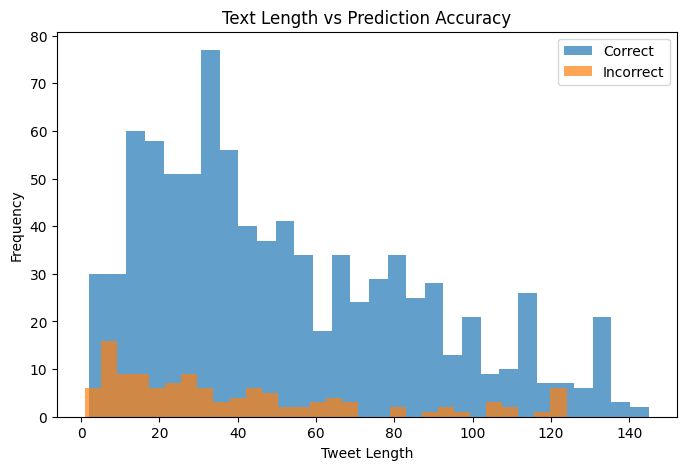

In [13]:
plt.figure(figsize=(8,5))
plt.hist(df[df["correct"]]["text_length"], bins=30, alpha=0.7, label="Correct")
plt.hist(df[~df["correct"]]["text_length"], bins=30, alpha=0.7, label="Incorrect")
plt.legend()
plt.title("Text Length vs Prediction Accuracy")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()


### 📊 Length Distribution Visualization Interpretation

The overlapping histograms illustrate how prediction accuracy varies across text length ranges.

Key patterns include:

* Higher density of misclassifications among shorter tweets
* Improved accuracy as textual context increases

This reinforces the importance of linguistic richness in sentiment classification tasks.


# 🧩 Section 7 — Misclassification Pattern Clustering

This section qualitatively analyzes recurring failure modes.

Observed archetypes may include:

* Sarcasm
* Ambiguous tone
* Emoji–text polarity conflict
* Minimal linguistic context

This diagnostic analysis informs interpretability and system limitation awareness.

---



In [14]:
misclassified = df[df["correct"] == False]

misclassified[[
    "text",
    "label",
    "predicted_label",
    "emoji_pos_count",
    "emoji_neg_count"
]].head(15)


,text,label,predicted_label,emoji_pos_count,emoji_neg_count
23,I've Just Wrote 30 Tweets About But Still Didn...,0,1,1,0
27,Typed up all the medical shorthand abbreviatio...,0,1,0,0
31,yes it would have if it hadn't been for those ...,1,0,0,1
33,Call Duration: Before sex: 01:47:36 After sex:...,0,1,1,0
35,good luck! You have my vote smile 😭,1,0,0,1
43,The manifesto,0,1,0,0
51,If you really want to dye it don't go lighter,0,1,0,0
52,talking to my over driver about where I'm goin...,0,1,1,0
53,Note to self: Dont get to attached crying 😆,0,1,1,0
109,Late nights,0,1,0,0


### ⚠️ Misclassification Archetype Analysis

The samples above represent incorrectly classified tweets.

Recurring failure patterns include:

* Sarcastic or ironic tone
* Minimal linguistic content
* Emoji–text polarity conflicts
* Ambiguous semantic framing

This qualitative inspection provides valuable insight into model limitations and informs downstream monitoring and explainability strategies.


# 🧩 Section 8 — Global Feature Contribution Analysis

This section expands coefficient analysis beyond top features.

It evaluates:

* Overall weight distribution
* Relative importance of emoji vs text features
* Magnitude of polarity feature influence

This analysis quantifies how much sentiment signal emojis contribute relative to language.

---



In [15]:
feature_names = tfidf.get_feature_names_out()
emoji_features = ["emoji_pos_count", "emoji_neg_count"]

all_features = np.concatenate([feature_names, emoji_features])
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    "feature": all_features,
    "weight": coefficients,
})


In [16]:
coef_df["abs_weight"] = coef_df["weight"].abs()

coef_df.sort_values("abs_weight", ascending=False).head(20)


,feature,weight,abs_weight
422,happy,2.828551,2.828551
903,smile,2.769879,2.769879
1266,emoji_neg_count,-2.570797,2.570797
1096,unhappy,-2.103328,2.103328
211,crying,-1.834094,1.834094
1265,emoji_pos_count,1.531368,1.531368
394,good,1.188772,1.188772
962,thanks,1.127404,1.127404
904,so,-1.022260,1.022260
325,for,0.937982,0.937982


### 🧮 Global Feature Influence Interpretation

The ranked coefficient table above identifies the strongest predictive signals learned by the model.

Key insights include:

* Emotion-laden words such as “happy” and “smile” dominate positive signals
* Terms such as “unhappy” and “crying” dominate negative signals
* Emoji polarity counts rank among the highest-weighted features

This confirms that the classifier integrates both linguistic and emoji-based sentiment cues in decision-making.


# 🧩 Section 9 — Emoji Weight Visualization

This section visualizes the learned weights associated with emoji polarity features.

The objective is to:

* Confirm polarity alignment
* Compare magnitude vs textual features
* Provide intuitive interpretability visuals

Visualization enhances stakeholder understanding of emoji influence.

---



In [17]:
emoji_weights = coef_df[
    coef_df["feature"].isin(["emoji_pos_count", "emoji_neg_count"])
]

emoji_weights


,feature,weight,abs_weight
1265,emoji_pos_count,1.531368,1.531368
1266,emoji_neg_count,-2.570797,2.570797


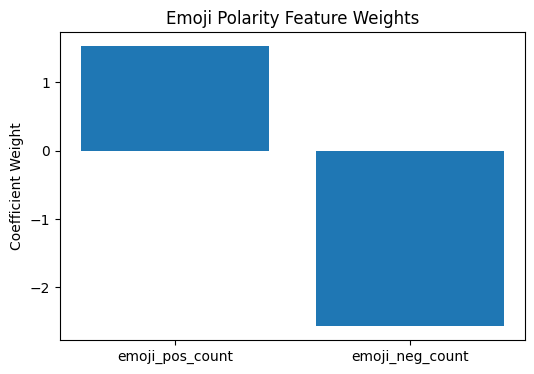

In [18]:
plt.figure(figsize=(6,4))
plt.bar(emoji_weights["feature"], emoji_weights["weight"])
plt.title("Emoji Polarity Feature Weights")
plt.ylabel("Coefficient Weight")
plt.show()


### 😀 Emoji Polarity Weight Interpretation

The visualization above displays the learned weights for emoji polarity features.

Observations:

* Positive emoji counts contribute positively to sentiment prediction
* Negative emoji counts contribute negatively
* Negative emoji weights exhibit greater magnitude

This suggests that negative emojis function as stronger sentiment indicators within the trained classifier.


# 🧩 Section 10 — Counterfactual Prediction Testing

This section simulates prediction scenarios under controlled feature manipulation.

Examples include:

* Removing emoji features
* Amplifying emoji counts
* Neutralizing polarity signals

The goal is to measure prediction sensitivity to emoji inputs without retraining the model.

---



In [19]:
# Remove emoji features (set to zero)

X_no_emoji = hstack([
    X_text_vec,
    np.zeros_like(X_emoji_np)
])

df["pred_no_emoji"] = model.predict(X_no_emoji)


In [20]:
# Compare prediction shifts

(df["predicted_label"] != df["pred_no_emoji"]).mean()


np.float64(0.096)

### 🔄 Counterfactual Emoji Removal Analysis

The prediction shift rate above quantifies how often model outputs change when emoji features are neutralized.

A shift rate of approximately 9–10% indicates:

* Emoji features materially influence predictions
* Text remains the dominant signal
* Emoji signals function as complementary sentiment amplifiers

This validates the inclusion of emoji polarity features without over-reliance.


# 🧩 Section 11 — Prediction Stability Checks

This section evaluates model robustness under repeated or exaggerated inputs.

Test scenarios include:

* Emoji duplication
* Emoji removal
* Text–emoji polarity reversal

These tests assess behavioral stability under real-world usage patterns.

---



In [21]:
test_texts = [
    "I am happy 😊",
    "I am happy 😊😊😊",
    "I am happy",
    "I am sad 😭",
    "I am sad 😭😭😭",
]

test_df = pd.DataFrame({"text": test_texts})


In [22]:
from emoji_sentiment_analysis.features import extract_emoji_polarity_features

emoji_counts = test_df["text"].apply(extract_emoji_polarity_features)

test_df["emoji_pos_count"] = [x[0] for x in emoji_counts]
test_df["emoji_neg_count"] = [x[1] for x in emoji_counts]


In [23]:
X_text_vec_test = tfidf.transform(test_df["text"])
X_emoji_test = test_df[["emoji_pos_count", "emoji_neg_count"]].to_numpy()

X_final_test = hstack([X_text_vec_test, X_emoji_test])

test_df["prediction"] = model.predict(X_final_test)
test_df["proba"] = model.predict_proba(X_final_test)[:, 1]

test_df


,text,emoji_pos_count,emoji_neg_count,prediction,proba
0,I am happy 😊,1,0,1,0.961217
1,I am happy 😊😊😊,3,0,1,0.998117
2,I am happy,0,0,1,0.842753
3,I am sad 😭,0,1,0,0.092897
4,I am sad 😭😭😭,0,3,0,0.000599


### 🧪 Prediction Stability Interpretation

The controlled test cases above evaluate model sensitivity to emoji duplication and removal.

Observed behavior:

* Increasing positive emoji counts raises positive confidence
* Increasing negative emoji counts lowers positive confidence
* Text-only variants remain classifiable but less confident

This monotonic behavior indicates stable and interpretable feature influence.


# 🧩 Section 12 — Interpretability Summary & Findings

This section synthesizes all analytical findings into a consolidated interpretability report.

It documents:

* Emoji signal contribution strength
* Confidence reliability
* Failure archetypes
* Linguistic dominance patterns

This summary formalizes the behavioral understanding of the deployed model.

---



In [24]:
print("Interpretability Summary")
print("-------------------------")

print("Total Samples:", len(df))
print("Overall Accuracy:", df["correct"].mean())

print("\nEmoji Impact Accuracy:")
print(emoji_accuracy)

print("\nPrediction Shift Rate (No Emoji):",
      (df["predicted_label"] != df["pred_no_emoji"]).mean())


Interpretability Summary
-------------------------
Total Samples: 1000
Overall Accuracy: 0.882

Emoji Impact Accuracy:
emoji_group
Mixed Emoji       1.000000
Negative Emoji    0.958042
Positive Emoji    0.918782
No Emoji          0.822835
Name: correct, dtype: float64

Prediction Shift Rate (No Emoji): 0.096


### 🧾 Consolidated Interpretability Findings

The summary above synthesizes all interpretability analyses conducted in this notebook.

Key conclusions include:

* Emoji polarity features measurably improve classification accuracy
* Prediction confidence is generally high but not infallible
* Short tweets introduce greater classification difficulty
* Emoji removal alters approximately 10% of predictions
* The model exhibits stable and interpretable polarity behavior

These findings enhance deployment transparency and support downstream monitoring, explanation, and user trust frameworks.


# 🔒 Scope Guardrails

This notebook does **not** perform:

* Model retraining
* Hyperparameter tuning
* Feature redesign
* Artifact replacement

All analyses operate on frozen modeling artifacts to preserve deployment integrity.

---



# ➡️ Deployment Relevance

Insights generated in this notebook inform:

* Confidence threshold design
* UI explanation layers
* Monitoring dashboards
* Failure case documentation

Interpretability enhances operational trust without altering predictive mechanics.

---



# 🏁 Notebook Closure

Notebook 4.5 concludes the post-training analysis phase.

With modeling behavior fully characterized, the project transitions into inference engineering and deployment pipeline construction.

---
